In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import pandas_profiling
import skfuzzy as fuzz
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('data/essalud_data_2017.csv')

In [10]:
df.head()

,Unnamed: 0,Consultas,Consultas de Atención Inmediata,Consultantes al Establecimiento,Consultantes Nuevos,Consultantes Asegurados,Médicos,Horas Médicas Programadas,Horas Médicas Efectivas,Consultorios Fisicos,...,Psicoprofilaxis de Nutrición,Psicoprofilaxis de Obstetricia,Visitas Domiciliarias de Enferm,Visitas Domiciliarias de Nutric,Visitas Domiciliarias de Obstet,Visitas Domiciliarias de T S,Psicoprofilaxis de Enfermería,Atenciones Psicología,Psicoprofilaxis de Psicología,Visitas Domiciliarias de Psicol
0,C.A.P.I-ANTABAMBA_per_2017-01,186.0,NaN,156.0,8.0,156.0,1.0,58.0,58.0,1.0,...,NaN,0.0,8.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN
1,C.A.P.I-ANTABAMBA_per_2017-02,109.0,NaN,56.0,3.0,56.0,1.0,66.0,58.0,1.0,...,NaN,0.0,6.0,NaN,14.0,NaN,NaN,NaN,NaN,NaN
2,C.A.P.I-ANTABAMBA_per_2017-03,163.0,NaN,70.0,5.0,70.0,1.0,81.0,73.0,1.0,...,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,C.A.P.I-ANTABAMBA_per_2017-04,145.0,NaN,43.0,3.0,43.0,1.0,80.0,72.0,1.0,...,NaN,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,C.A.P.I-ANTABAMBA_per_2017-05,159.0,NaN,41.0,7.0,41.0,1.0,84.0,82.0,1.0,...,NaN,0.0,0.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN


In [4]:
report = pandas_profiling.ProfileReport(df)

In [5]:
report.to_file(outputfile='report.html')

In [11]:
counter = 0
columns = [] # List of columns to impute missing (NA) values 
for column in df.columns:
    if df[pd.isnull(df[column])].shape[0]/df.shape[0] < .8:
        counter += 1
        columns.append(column)
print('# Columns > 80% NA values: ', counter)

# Columns > 80% NA values:  69


In [13]:
# Imputing missing (NA) values using the column mean
df_mean = df[columns]
for column in df_mean.columns:
    if column != 'Unnamed: 0':
        df_mean.loc[:, column] = df_mean[column].fillna(df_mean[column].mean()).astype(int)

In [12]:
# Imputing missing (NA) values using the column median
df_median = df[columns]
for column in df_median.columns:
    if column != 'Unnamed: 0':
        df_median.loc[:, column] = df_median[column].fillna(df_median[column].median()).astype(int)

4776


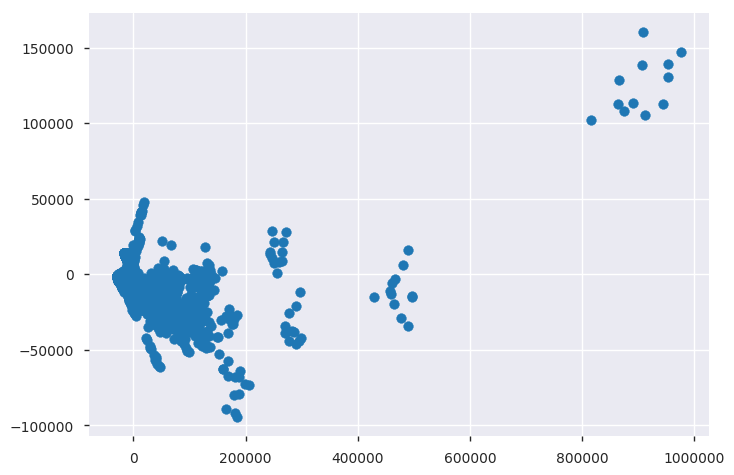

In [16]:
pca = PCA(n_components=0.95)

pc = pd.DataFrame(pca.fit_transform(df_mean[df_mean.keys()[1:]]))

print(len(pc))

plt.scatter(pc[0], pc[1])
plt.show()

In [17]:
def cluster_hospitals(df, year, exp_var=0.95, index_col='Unnamed: 0', n_clusters = 11):
    
    periods = ['01','02','03','04','05','06','07','08','09','10','11','12']
    
    c_periods = [[] for i in range(n_clusters + 1)]
    
    for period in tqdm(range(len(periods))):
        
        t = df[df[index_col].str.contains('{}-{}'.format(year, periods[period]))]
        pca = PCA(n_components=0.95)

        pc = pd.DataFrame(pca.fit_transform(t[t.keys()[1:]]))
        
        cntrs, us, u0s, ds, jms, ps, fpcs, sils = [],[],[],[],[],[],[], []
        
        for i in range(2, n_clusters):
            cntr, u, u0, d, jm, p, fpc = fuzz.cmeans(pc.T, i, 2, error=0.005, maxiter=1500)
            labels = np.argmax(u.T, axis=1)
            cntrs.append(cntr)
            us.append(u)
            u0s.append(u0)
            ds.append(d),
            jms.append(jm)
            ps.append(p)
            fpcs.append(fpc)
            sils.append(silhouette_score(pc, labels))
            
        c_periods[period].append([cntrs, us, u0s, ds, jms, ps, fpcs, sils])
    return c_periods

In [19]:
#cntrs, us, u0s, ds, jms, ps, fpcs, sils = cluster_hospitals(df_mean)

c_periods = cluster_hospitals(df_mean, 2017)

100%|██████████| 12/12 [00:03<00:00,  3.67it/s]


In [27]:
len(c_periods[0])

1

In [21]:
c_periods[11][0][-1]

[0.8095245586213207,
 0.7846702346427576,
 0.6938435239318224,
 0.5520074412222057,
 0.5734012383388943,
 0.6702268738439039,
 0.6649823471018343,
 0.6574687516474029,
 0.6334983070280041]

In [39]:
len(c_periods[1][0][-1])

9

In [41]:
periods = ['01','02','03','04','05','06','07','08','09','10','11','12']

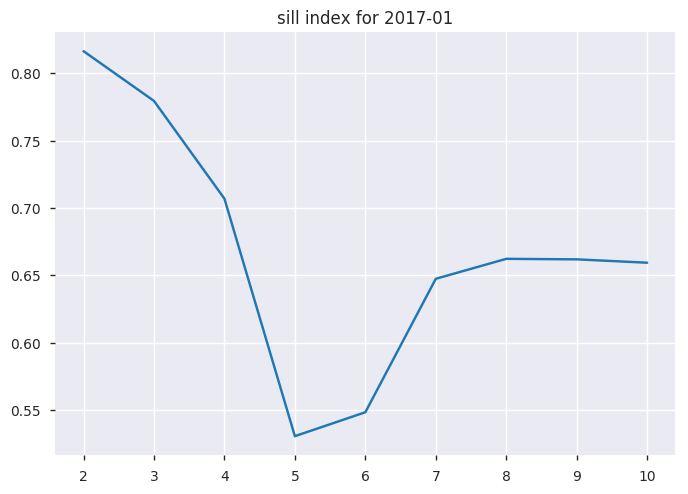

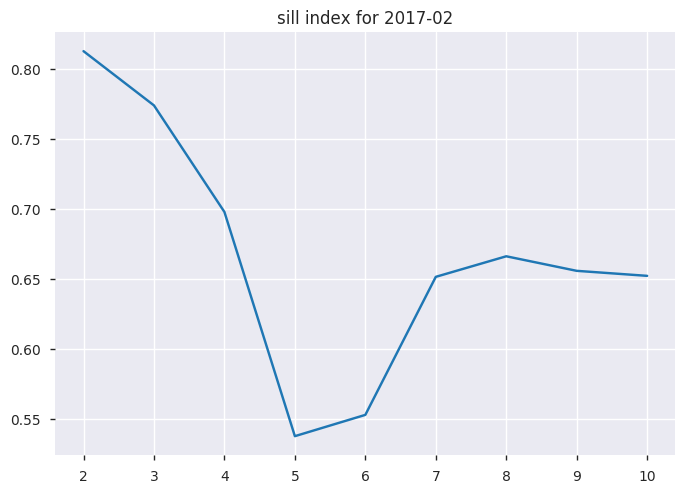

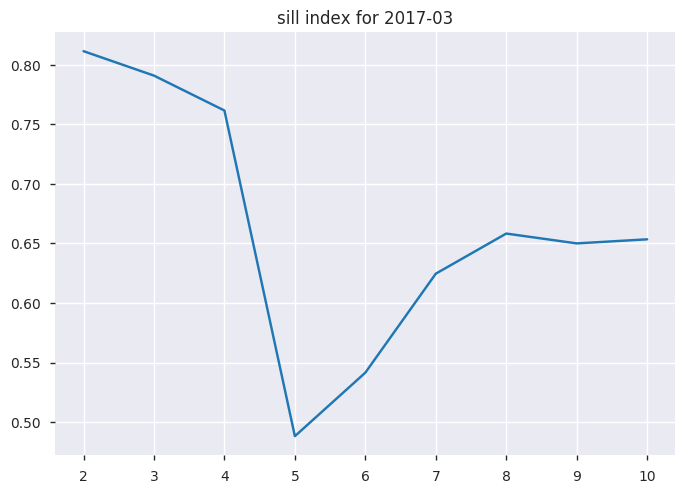

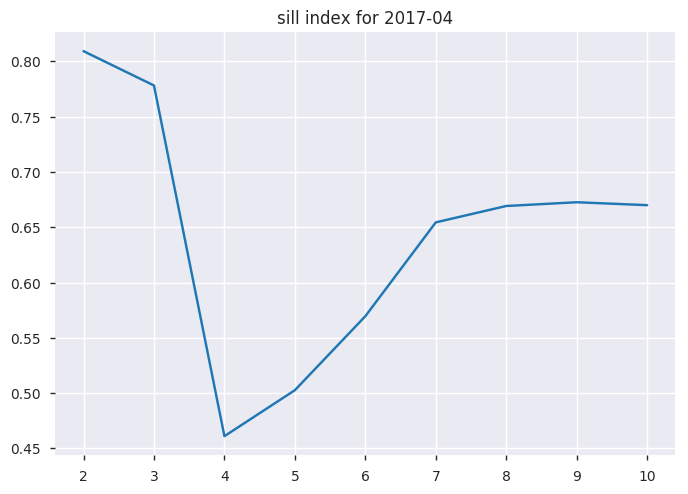

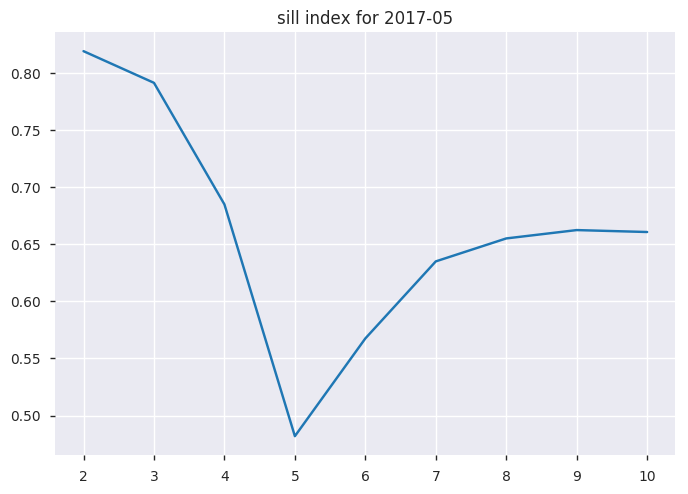

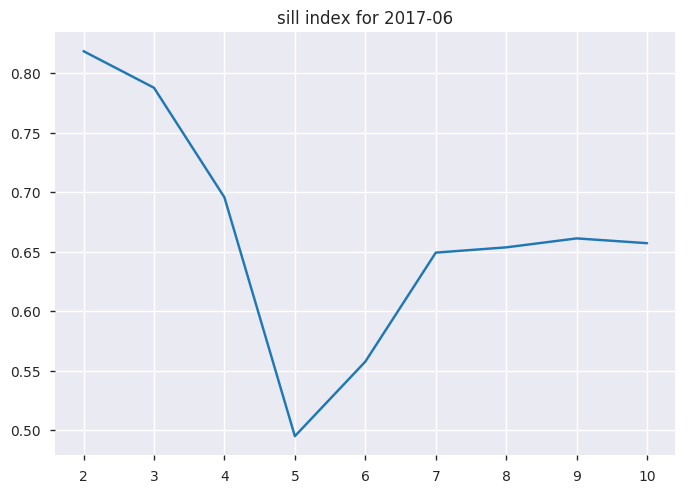

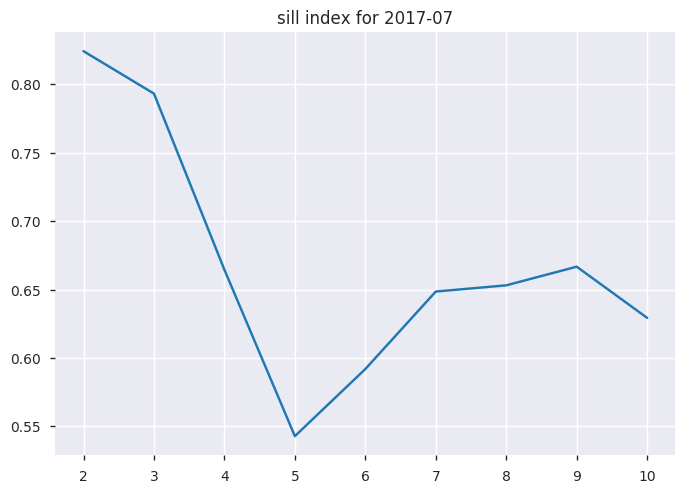

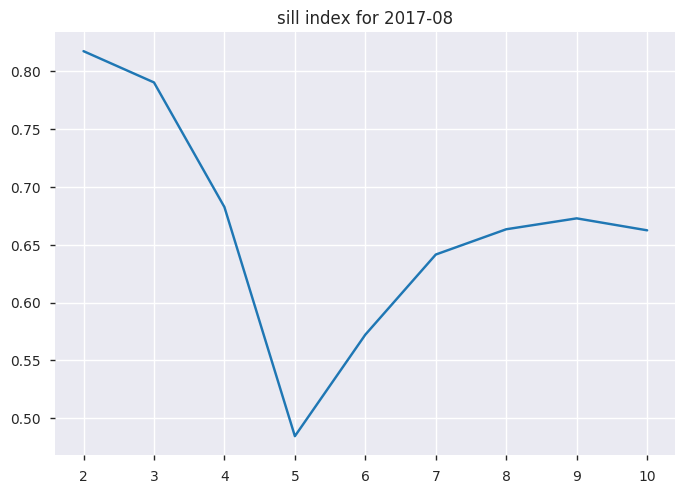

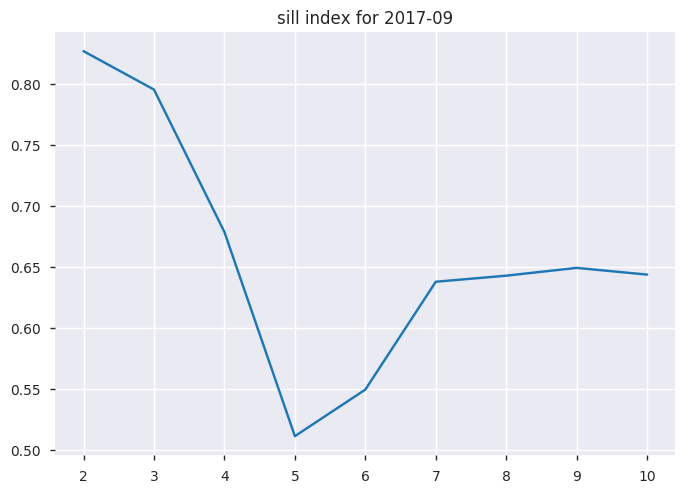

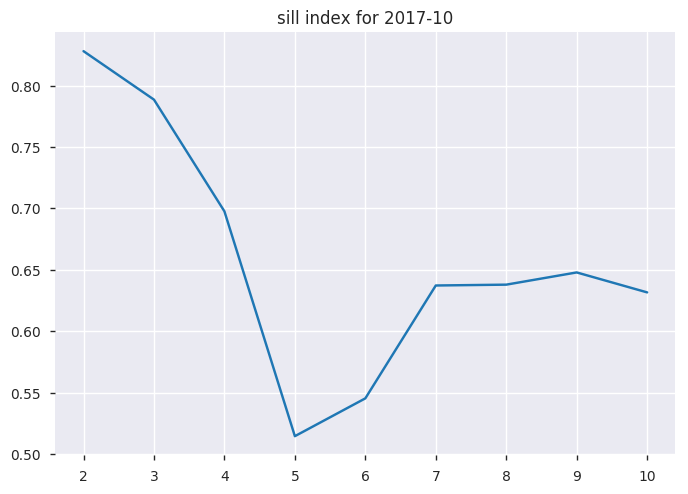

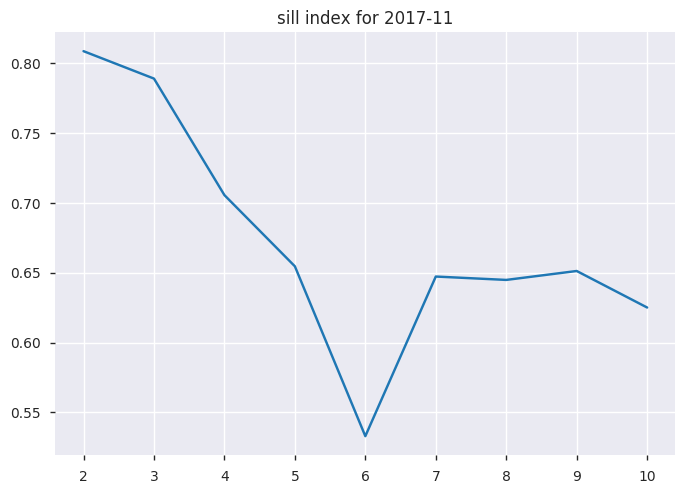

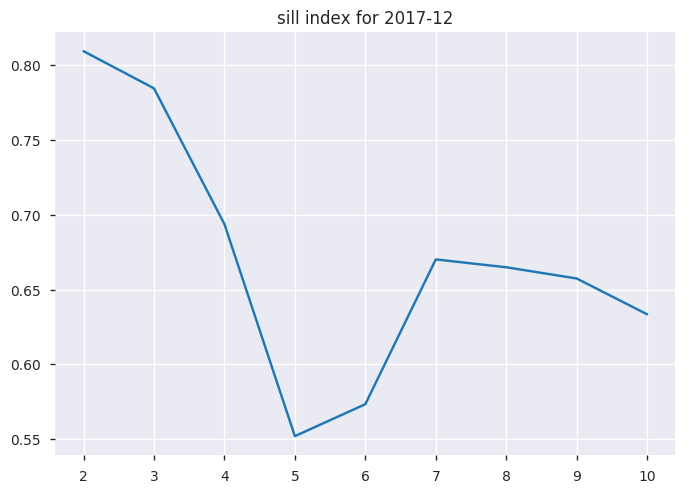

In [42]:
for i in range(12):
    for j in range(len(c_periods[i])):
        plt.plot(range(2,11),c_periods[i][j][-1])
        plt.title('sill index for 2017-{}'.format(periods[i]))
        plt.show()

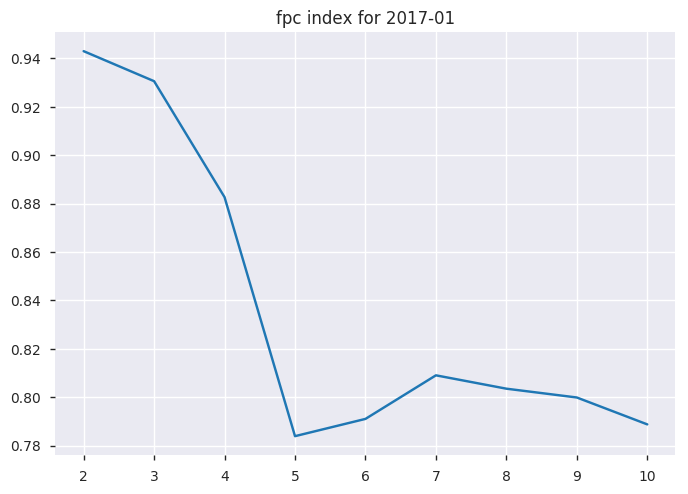

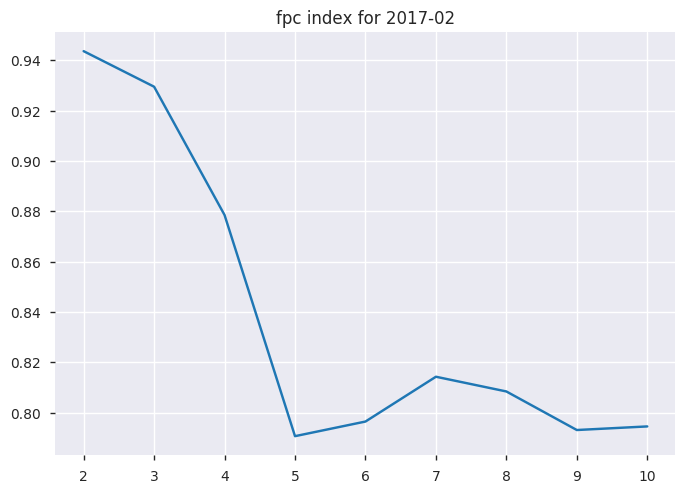

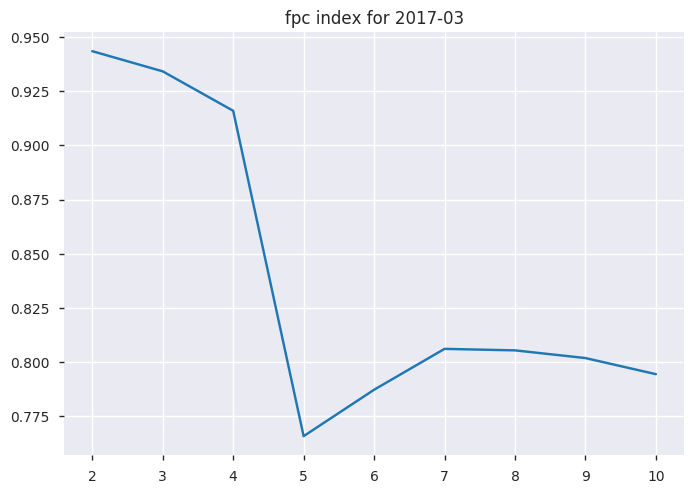

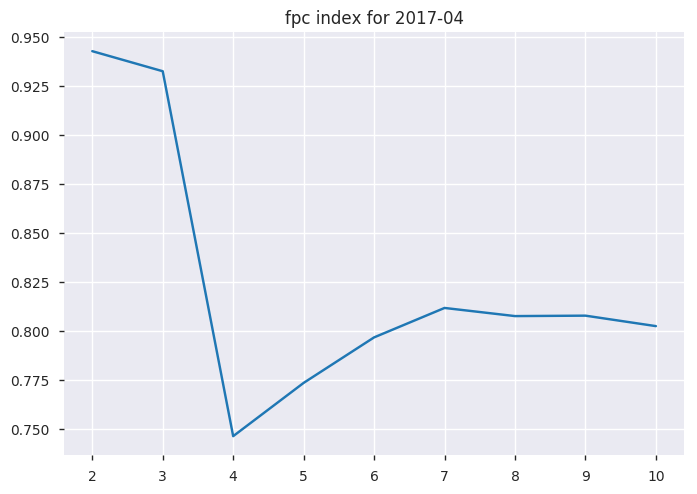

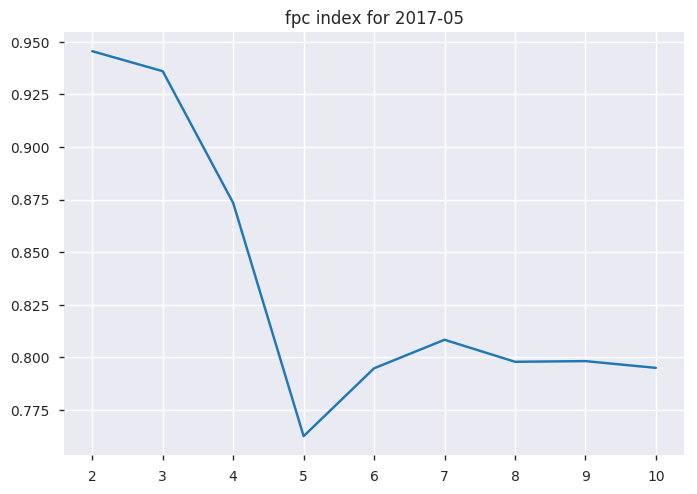

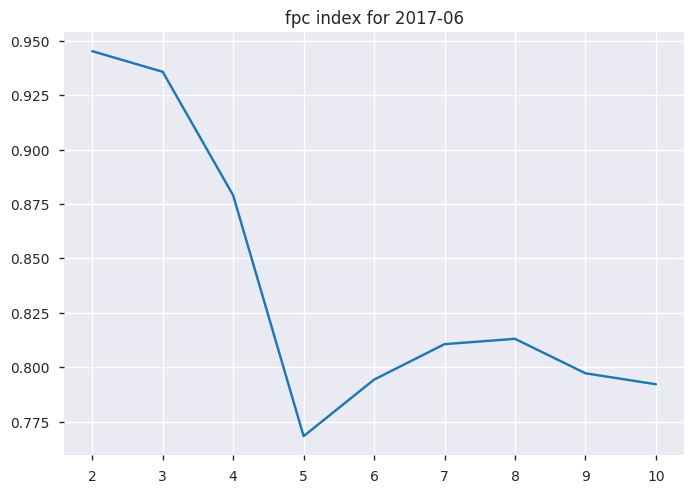

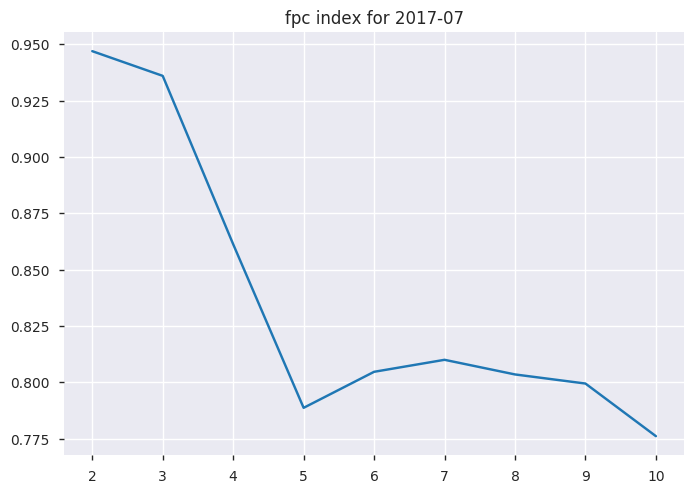

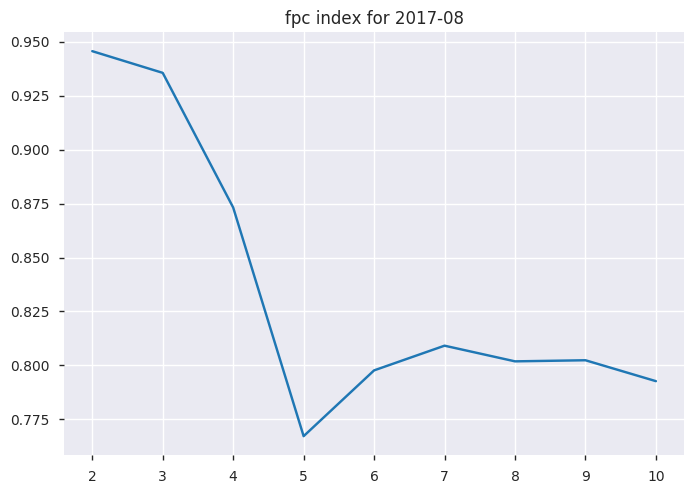

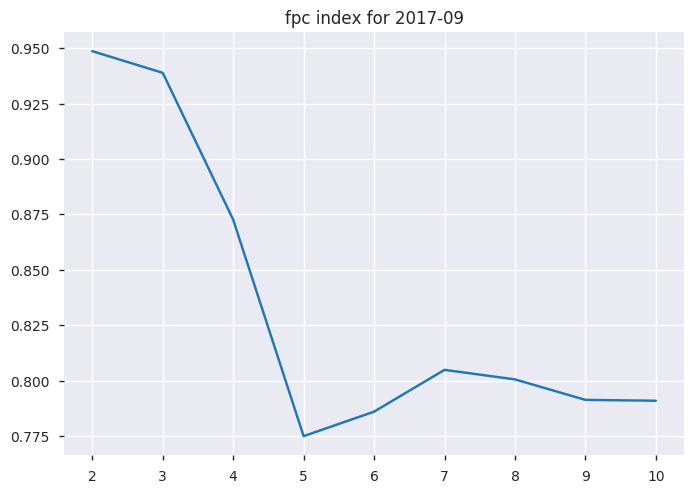

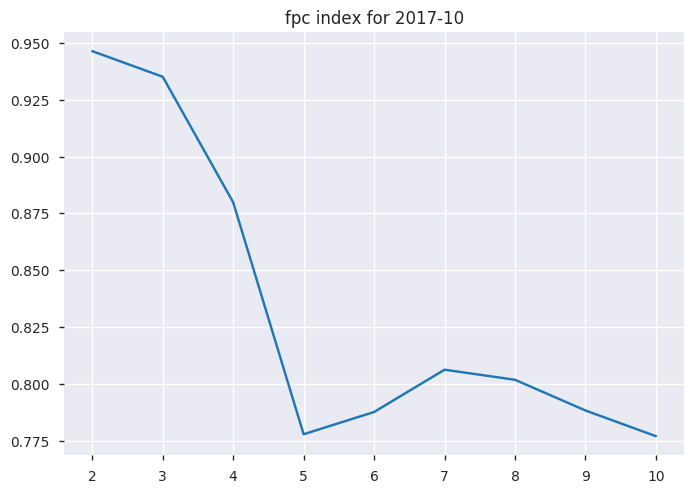

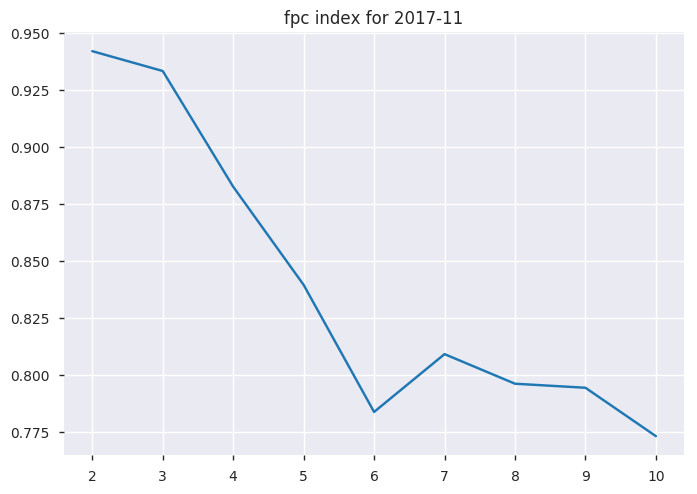

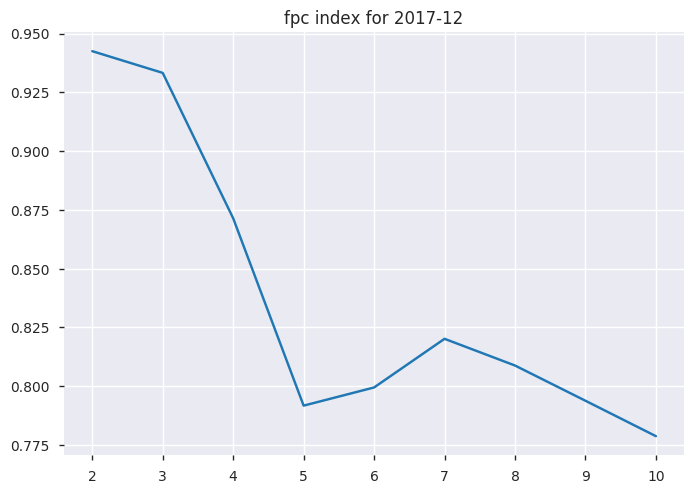

In [44]:
for i in range(12):
    for j in range(len(c_periods[i])):
        plt.plot(range(2,11),c_periods[i][j][-2])
        plt.title('fpc index for 2017-{}'.format(periods[i]))
        plt.show()